# `kts` Workflow
I conduct experiments in a separate notebook, like this one. The structure is very similar to one I use in real competitions.  
*In Italic I give tips and tricks on project organization and best practices of kts usage.*

In [1]:
%pylab inline
import pandas as pd
import kts
from kts import *

Populating the interactive namespace from numpy and matplotlib


`kts.ls()` returns list of objects stored in user cache.  
`kts.features` is a list of all registered feature constructors  
`kts.features.define_in_scope()` makes them visible in current notebook

## Data Loading

In [2]:
kts.ls()
features
features.define_in_scope(globals())

['train', 'test']

[family_size, family_size_encode, encode_age_and_sex, select_numeric]

In [3]:
%%time
train = kts.load('train')
test = kts.load('test')

CPU times: user 13.2 ms, sys: 4.36 ms, total: 17.6 ms
Wall time: 18.1 ms


## FeatureSet Section
*I usually save all history of FeatureSet creation at one place. My default naming is `fs_i` for easy tracking. Don't create different FeatureSets with one name, as this may prevent you from clear understanding which one was used to conduct a certain experiment.*

Now we can define our first `FeatureSet`. It is a container for trying out different combinations of created features. 

Some features are to be computed after splitting to avoid leaks. Such features can be specified with `fc_after` argument, whose name means "FeatureConstructor which will be computed after split". For example, target encoding should be done after split. In general, any function which behaves differently being called on train and on validation dataframe, should be passed to `fc_after`.

Other functions can be precomputed for all the data, and should be passed to `fc_before`. 

`df_input` specifies a training dataframe, `target_column` meaning is obvious, and `description` argument is optional and may be used to take notes about current set of features.

Signature:
`FeatureSet(fc_before, fc_after, df_input, target_column, description)`

In [4]:
fs_1 = FeatureSet(select_numeric,
                  df_input=train,
                  target_column='Survived',
                  description='Baseline: original numeric features'
                 )

## Validation Section

`Validator(sklearn_splitter, sklearn_metric)` is used to validate models on features.

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(5)
val = Validator(skf, roc_auc_score)

It's time to create our first model.   
*`zoo.bc` is an alias of `zoo.binary_classification`*  
`val.score(model, featureset, **kwargs_for_model_training)` validates the model using featureset and saves everything needed for reproducing the experiment.

In [6]:
cb = zoo.bc.CatBoostClassifier()
val.score(cb, fs_1, description='baseline catboost on numeric features', verbose=500)

Learning rate set to 0.075294
0:	learn: 0.6745933	test: 0.6831137	best: 0.6831137 (0)	total: 90.5ms	remaining: 1m 30s
500:	learn: 0.3880297	test: 0.6834484	best: 0.6439855 (11)	total: 6.13s	remaining: 6.11s
999:	learn: 0.3484651	test: 0.7012846	best: 0.6439855 (11)	total: 9.47s	remaining: 0us

bestTest = 0.6439855404
bestIteration = 11

Shrink model to first 12 iterations.
Learning rate set to 0.075294
0:	learn: 0.6778134	test: 0.6799557	best: 0.6799557 (0)	total: 25.7ms	remaining: 25.7s
500:	learn: 0.3589846	test: 0.6762786	best: 0.5952019 (30)	total: 3.92s	remaining: 3.9s
999:	learn: 0.3142669	test: 0.7347344	best: 0.5952019 (30)	total: 11.2s	remaining: 0us

bestTest = 0.5952018535
bestIteration = 30

Shrink model to first 31 iterations.
Learning rate set to 0.075305
0:	learn: 0.6736918	test: 0.6737273	best: 0.6737273 (0)	total: 44.2ms	remaining: 44.1s
500:	learn: 0.3814892	test: 0.5722896	best: 0.5573633 (59)	total: 6.7s	remaining: 6.67s
999:	learn: 0.3354125	test: 0.5943439	best: 0

0.750426074371439

After validation you get the score and ID of your model, `B1C44F` in this case. ID is used to access the experiment via `leaderboard`.  
*`lb` is an alias of `leaderboard`*  
Leaderboard saves your experiments sorted by score.

In [11]:
lb

,Score,std,Model,FS,Description,FS description,Model source,FS source,Splitter
ID,,,,,,,,,
B1C44F,0.750426,0.0642686,cb_default,fs_1,baseline catboost on numeric features,Baseline: original numeric features,CatBoostClassifier(loss_function='Logloss'),"FeatureSet(fc_before=select_numeric, fc_after=stl.empty_like, target_column='Survived', group_column=None)","StratifiedKFold(n_splits=5, random_state=None, shuffle=False)"


An experiment saves your models, the featureset and other service info.

In [12]:
print(type(lb['B1C44F']))
lb['B1C44F']

<class 'kts.validation.experiment.Experiment'>


+----------------+-------------------------------------------------------------+
| Score          | 0.7504261, std: 0.0642686 (roc_auc_score)                   |
+----------------+-------------------------------------------------------------+
| Identifier     | B1C44F                                                      |
+----------------+-------------------------------------------------------------+
| Description    | baseline catboost on numeric features                       |
+----------------+-------------------------------------------------------------+
| Model          | cb_default       x5                                         |
+----------------+-------------------------------------------------------------+
| |- source      | CatBoostClassifier(loss_function='Logloss')                 |
+----------------+-------------------------------------------------------------+
| FeatureSet     | fs_1                                                        |
+----------------+----------

You can pass a dataframe with the same columns as training one to Experiment and get predictions for it. The features will be computed automatically.

In [13]:
lb['B1C44F'].predict(test)

array([0.21662121, 0.10902314, 0.28929278, 0.23626603, 0.42023217,
       0.2856266 , 0.22241966, 0.57427817, 0.25561417, 0.30584526,
       0.25936094, 0.48227903, 0.73138137, 0.32574562, 0.62032488,
       0.48164349, 0.41450895, 0.24610827, 0.25201219, 0.13940482,
       0.61740209, 0.21152199, 0.53036166, 0.70874216, 0.68150581,
       0.20895617, 0.71306049, 0.24514959, 0.53790262, 0.38279244,
       0.41392976, 0.46490308, 0.3964912 , 0.48622277, 0.6740473 ,
       0.25561417, 0.24908434, 0.22507589, 0.25864456, 0.48313229,
       0.30884325, 0.51915326, 0.18595727, 0.40919981, 0.58223663,
       0.23987025, 0.50929476, 0.30975755, 0.58722942, 0.39747644,
       0.68235961, 0.41876449, 0.58886201, 0.71489795, 0.48517269,
       0.14582299, 0.21027194, 0.25591826, 0.39867743, 0.7683757 ,
       0.2524516 , 0.40992249, 0.2955441 , 0.26720616, 0.75667596,
       0.52250778, 0.27686475, 0.4743575 , 0.56140917, 0.50507018,
       0.27684216, 0.23553292, 0.24015098, 0.5542787 , 0.75760

In [14]:
exp = lb['B1C44F']

You can visualize feature importances:  
*Each bar line consists of three sectors divided by color intensity. The lightest is maximum importance among all folds, second is mean, and the least one is std.*

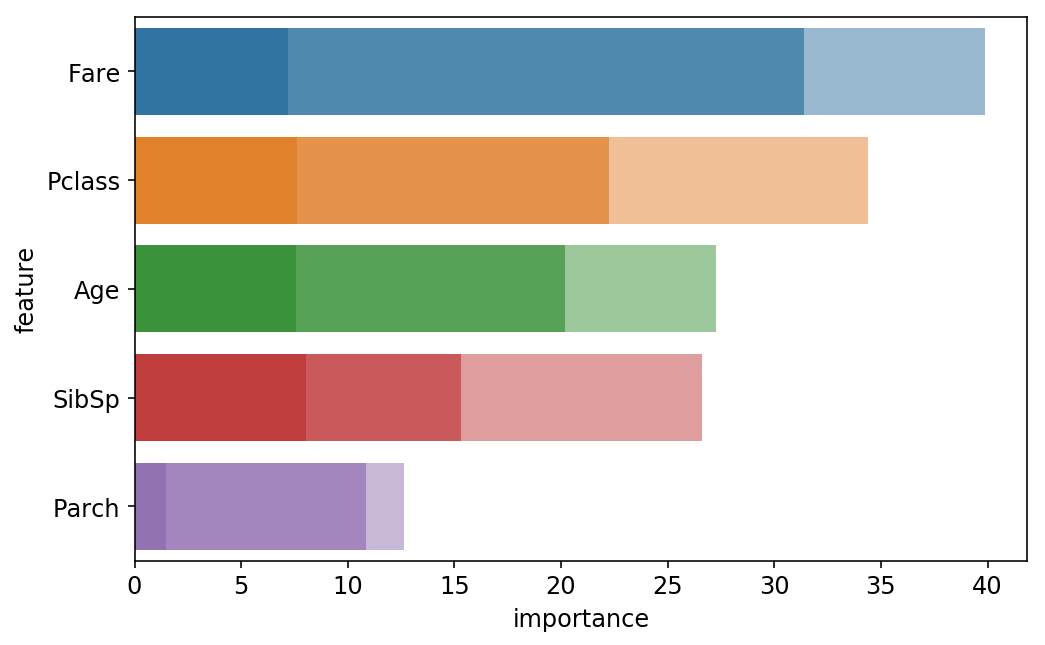

In [22]:
exp.feature_importances(plot=True)
# std:mean:max

If you have `eli5` preinstalled, you may want to compute permutation importances instead of builtin importances computed automatically by CatBoost:

In [16]:
# Experiment doesn't store a training dataframe inside, so you should set it to compute permutation importances on val folds:
exp.set_df(train)

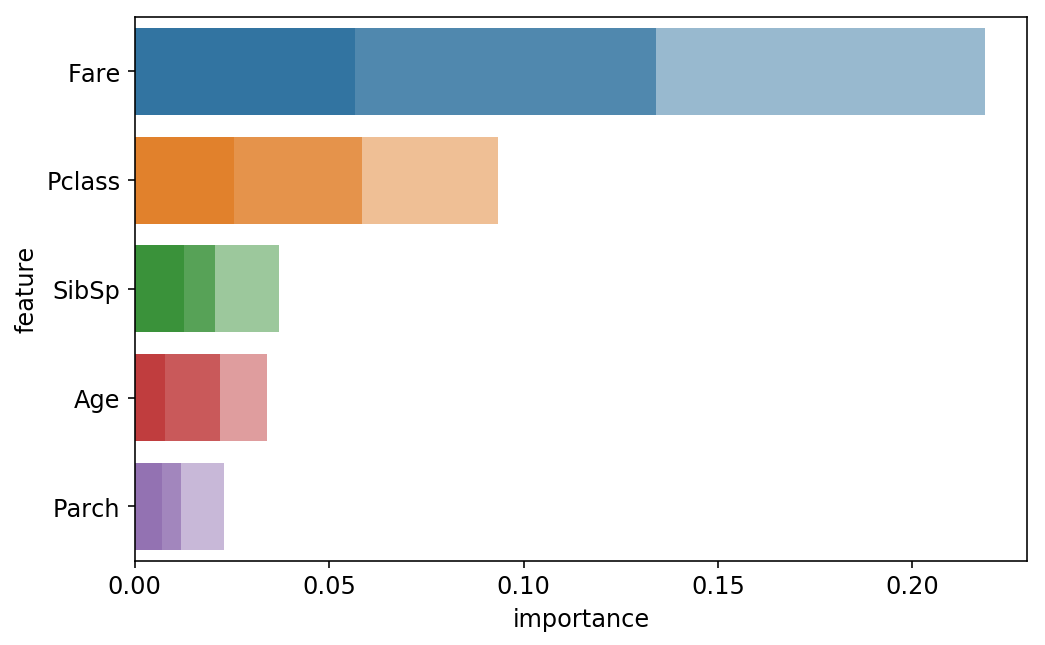

In [24]:
exp.feature_importances(plot=True, importance_calculator=kts.selection.PermutationImportance())

It was only one iteration. During a real competition FeatureSet Section consists of 20-50 featuresets, and Validation Section is changed continuously, as there's no reason to save model initialization and `val.score()` lines, as it is all stored in Experiment.

Now you can proceed to `ModelingFull.ipynb` where I omit details from current notebook and show a workflow more similar to real one.